# EfficientNetV2S

#### Setup

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import PIL
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint
from skimage.io import imread
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sn
import pandas as pd

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 22 23:16:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
#Configuration environment

import os

os.environ['KAGGLE_USERNAME'] = "nataliacanto"

# username from the json file

os.environ['KAGGLE_KEY'] = "22dfa81f4539576eee33ca26ac952deb"

# key from the json file

In [ ]:
# set where to open it
%cd /content

/content


In [ ]:
# confirm
!pwd

/content


In [ ]:
#download from kaggle
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [02:34<00:00, 23.3MB/s]
100% 3.10G/3.10G [02:34<00:00, 21.5MB/s]


In [ ]:
#unzip files
!unzip -q '/content/breast-histopathology-images.zip'

#### Drive mount

In [ ]:
### click on the final link to give access to the institutional drive ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123074 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data Load

In [ ]:
### natalia read ###
df = pd.read_csv('/content/drive/MyDrive/Doutorado/Ciência e análise de dados/projeto/datasets/processed/bhi_data.csv')

In [ ]:
df.head()

,patient_id,path,target
0,14079,/content/IDC_regular_ps50_idx5/14079/0/14079_i...,0
1,14079,/content/IDC_regular_ps50_idx5/14079/0/14079_i...,0
2,14079,/content/IDC_regular_ps50_idx5/14079/0/14079_i...,0
3,14079,/content/IDC_regular_ps50_idx5/14079/0/14079_i...,0
4,14079,/content/IDC_regular_ps50_idx5/14079/0/14079_i...,0


Split by patients

In [ ]:
# number of patients
num_patients = df['patient_id'].nunique()
num_patients

279

In [ ]:
# number of patients for each set
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_train_patients = int(num_patients * train_ratio)
num_val_patients = int(num_patients * val_ratio)
num_test_patients = num_patients - num_train_patients - num_val_patients

unique_patients = df['patient_id'].unique() # get the ids
random.seed(11)
random.shuffle(unique_patients) # randomize the order

# split the patients
train_patients = unique_patients[:num_train_patients]
val_patients = unique_patients[num_train_patients:num_train_patients + num_val_patients]
test_patients = unique_patients[num_train_patients + num_val_patients:]

# create df for each set
train_df = df[df['patient_id'].isin(train_patients)]
val_df = df[df['patient_id'].isin(val_patients)]
test_df = df[df['patient_id'].isin(test_patients)]

In [ ]:
# count by target to see data balance
print('train:', train_df.groupby('target').size())
print('val:', val_df.groupby('target').size())
print('test:', test_df.groupby('target').size())

train: target
0    142774
1     55437
dtype: int64
val: target
0    23903
1     9296
dtype: int64
test: target
0    32061
1    14053
dtype: int64


Truncating the dataset

In [ ]:
def group_size(dataset):
  # Group the DataFrame by the target column
  grouped = dataset.groupby('target')
  # Determine the size of the smaller group
  group_size = grouped.size().min()
  return grouped, group_size

grouped_train, gsize_train = group_size(train_df)
grouped_val, gsize_val = group_size(val_df)
grouped_test, gsize_test = group_size(test_df)

In [ ]:
def truncating(grouped, gsize):
  samples = gsize//2

  # Sample the same number of rows from each group randomly
  truncated_df = grouped.apply(lambda x: x.sample(n=samples, random_state=11))

  # Reset the index of the truncated DataFrame
  truncated_df = truncated_df.reset_index(drop=True)
  return truncated_df

truncated_train = truncating(grouped_train, gsize_train)
truncated_val = truncating(grouped_val, gsize_val)
truncated_test = truncating(grouped_test, gsize_test)

print('truncated train', truncated_train.groupby('target').size())
print('truncated val', truncated_val.groupby('target').size())
print('truncated test', truncated_test.groupby('target').size())

truncated train target
0    27718
1    27718
dtype: int64
truncated val target
0    4648
1    4648
dtype: int64
truncated test target
0    7026
1    7026
dtype: int64


In [ ]:
truncated_df.groupby('target').size()

target
0    39393
1    39393
dtype: int64

Read file

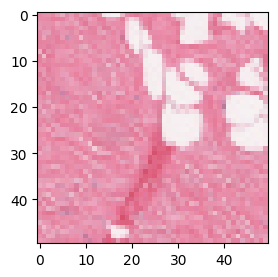

In [ ]:
filepath = truncated_train.loc[0, "path"]
plt.figure(figsize=(3,3))
img = tf.io.read_file(filepath)
img = tf.image.decode_png(img, channels=3)
plt.imshow(img)
plt.show()

In [ ]:
# load images
def load_image(filepath):
  # read image
  image = tf.io.read_file(filepath)
  # decode to tensor format
  image = tf.image.decode_png(image, channels=3) #rgb image expand_animations=False,
  return image

# split dataset
def ds_split(ds, ds_size, train_split=0.9, val_split=0.1, shuffle=False):
    assert (train_split + val_split) == 1

    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    #test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds

In [ ]:
# image and batch size
size = 50
batch_size=64

def create_dataset(truncated_df):
  # Load the images and targets
  image_paths = truncated_df['path'].tolist()
  targets = truncated_df['target'].tolist()

  # Create a dataset of image paths and targets
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, tf.keras.utils.to_categorical(targets)))

  # Map the dataset to load and preprocess the images
  dataset = dataset.map(lambda x, y: (load_image(x), y)).shuffle(dataset.cardinality().numpy())
  return dataset

x_train = create_dataset(truncated_train)
x_valid = create_dataset(truncated_val)
x_test = create_dataset(truncated_test)

In [ ]:
dataset.cardinality().numpy()

78786

In [ ]:
# split dataset into train, valid and test sets
#x_train_x, x_test = ds_split(dataset, dataset.cardinality().numpy(), train_split=0.7, val_split=0.3)
#x_train, x_valid = ds_split(x_train_x, x_train_x.cardinality().numpy(), train_split=0.8, val_split=0.2)

In [ ]:
#x_train_x.cardinality().numpy()

55150

In [ ]:
#x_test.cardinality().numpy()

23635

In [ ]:
# preprocess images
x_train1 = x_train.map(lambda x,y: (preprocess_input(tf.image.resize_with_crop_or_pad(x, size, size)*255),y), num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache()
x_train1 = x_train1.prefetch(1)

x_val1 = x_valid.map(lambda x,y: (preprocess_input(tf.image.resize_with_crop_or_pad(x, size, size)*255),y), num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache()
x_val1 = x_val1.prefetch(1)

x_test1 = x_test.map(lambda x, y: (preprocess_input(tf.image.resize_with_crop_or_pad(x, size, size)*255), y), num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder=True).cache()
x_test1 = x_test1.prefetch(1)

In [ ]:
x_train1.cardinality().numpy()

866

In [ ]:
x_test1.cardinality().numpy()

219

In [ ]:
x_val1.cardinality().numpy()

145

#### Random Initialization

In [ ]:
def non_pre_trained_model(input_shape, n_classes, optimizer, fine_tune=0):
    """
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training.
    fine_tune: int - The number of pre-trained layers to unfreeze.
               0 = all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    efficientnetv2s_model = EfficientNetV2S(include_top=True,
                     weights=None,
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    '''
    if fine_tune > 0:
        for layer in efficientnetv2s_model.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in efficientnetv2s_model.layers:
            layer.trainable = False
    '''

    # Turn all the layers trainable.

    for layer in efficientnetv2s_model.layers:
      layer.trainable = True

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = efficientnetv2s_model.layers[-2].output
    #top_model = Flatten(name="flatten")(top_model)
    #top_model = Dense(4096, activation='relu')(top_model)
    #top_model = Dense(128, activation='relu')(top_model)
    #top_model = Dropout(0.25)(top_model)
    output_layer = Dense(n_classes, activation='softmax', name='my_predictions')(top_model)

    # Group the convolutional base and new output into a Model object.
    model = Model(inputs=efficientnetv2s_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tf.random.set_seed(s) #s
opt = Adam(learning_rate=0.001)
EfficientNetV2S_model = non_pre_trained_model(input_shape=(size,size,3), n_classes=2, optimizer=opt)

In [ ]:
print(EfficientNetV2S_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 rescaling_1 (Rescaling)        (None, 50, 50, 3)    0           ['input_2[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 25, 25, 24)   648         ['rescaling_1[0][0]']            
                                                                                                  
 stem_bn (BatchNormalization)   (None, 25, 25, 24)   96          ['stem_conv[0][0]']              
                                                                                            

In [ ]:
# ModelCheckpoint callback - save best weights -
w_path = '/content/drive/MyDrive/Doutorado/Ciência e análise de dados/projeto/datasets/processed/model_bhi_efficientnetv2s_rdn_v2.weights.best.hdf5'
estopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
checkpoint = ModelCheckpoint(filepath=w_path, save_best_only=True, verbose=0)
history = EfficientNetV2S_model.fit(x_train1, validation_data=x_val1, epochs=20, verbose=1, shuffle=True, callbacks=[checkpoint, estopping]) #validation_split=0.1

Epoch 1/20
866/866 [==============================] - 182s 112ms/step - loss: 0.4702 - accuracy: 0.8014 - val_loss: 0.5011 - val_accuracy: 0.8031
Epoch 2/20
866/866 [==============================] - 84s 98ms/step - loss: 0.4091 - accuracy: 0.8284 - val_loss: 0.6994 - val_accuracy: 0.6913
Epoch 3/20
866/866 [==============================] - 94s 109ms/step - loss: 0.4203 - accuracy: 0.8213 - val_loss: 0.4577 - val_accuracy: 0.7987
Epoch 4/20
866/866 [==============================] - 95s 110ms/step - loss: 0.3966 - accuracy: 0.8288 - val_loss: 0.4288 - val_accuracy: 0.8164
Epoch 5/20
866/866 [==============================] - 96s 111ms/step - loss: 0.3666 - accuracy: 0.8435 - val_loss: 0.4273 - val_accuracy: 0.8144
Epoch 6/20
866/866 [==============================] - 96s 111ms/step - loss: 0.3597 - accuracy: 0.8479 - val_loss: 0.4213 - val_accuracy: 0.8137
Epoch 7/20
866/866 [==============================] - 83s 96ms/step - loss: 0.3589 - accuracy: 0.8473 - val_loss: 0.4448 - val_acc

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots with two rows and one column
fig = make_subplots(rows=1, cols=2)

# Add the loss and validation loss traces to the first subplot
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='loss'), row=1, col=1)
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='val_loss'), row=1, col=1)

# Configure the layout for the loss plot
fig.update_xaxes(title_text='Epoch', row=1, col=1)
fig.update_yaxes(title_text='Loss', row=1, col=1)

# Add the accuracy and validation accuracy traces to the second subplot
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines', name='accuracy', line=dict(color='green')), row=1, col=2)
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='val_accuracy'), row=1, col=2)

# Configure the layout for the accuracy plot
fig.update_xaxes(title_text='Epoch', row=1, col=2)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)

# Update the overall layout
fig.update_layout(title='Loss and Accuracy Evolution', showlegend=True, template='plotly_white')

# Show the plot
fig.show()


In [ ]:
### TEST ACCURACY ###
scores = EfficientNetV2S_model.evaluate(x_test1)
print('\n%s : %.2f%%' % (EfficientNetV2S_model.metrics_names[1], scores[1] * 100))

219/219 [==============================] - 7s 30ms/step - loss: 0.5981 - accuracy: 0.8326

accuracy : 83.26%


##### Confusion matrix

In [ ]:
# Extract only the labels from the test set
y_test_dataset = x_test1.map(lambda x, y: y)

# Convert the labels dataset to a NumPy array
y_test = np.asarray(list(y_test_dataset.unbatch().as_numpy_iterator()))
print(len(y_test))

14016


In [ ]:
y_pred = EfficientNetV2S_model.predict(x_test1)
print(y_pred.shape)

219/219 [==============================] - 9s 29ms/step
(14016, 2)


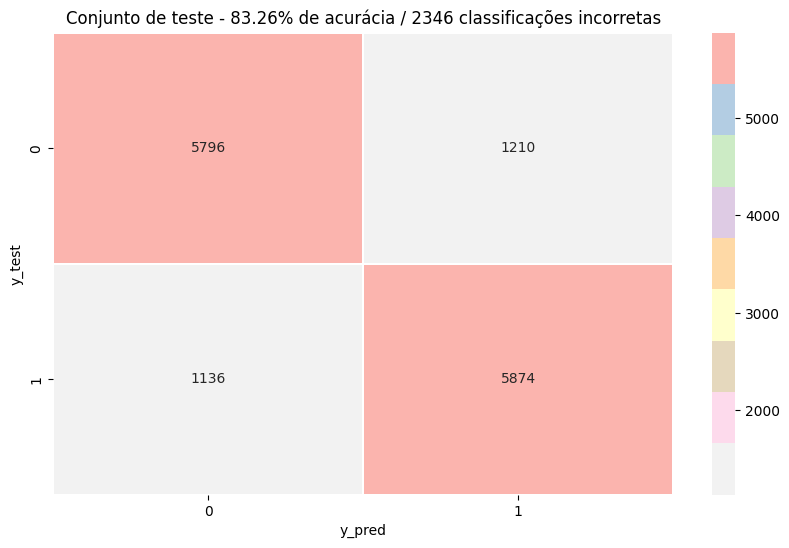

In [ ]:
plt.figure(figsize = (10,6))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1))
acc = np.trace(cm)/14016 * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
### plot some metrics ###

import plotly.graph_objects as go
def metrics_from_cm(confusion_matrixx):
  FP = np.sum(confusion_matrixx, axis=0) - np.diag(confusion_matrixx)
  FN = np.sum(confusion_matrixx, axis=1) - np.diag(confusion_matrixx)
  TP = np.diag(confusion_matrixx)
  TN = np.sum(confusion_matrixx) - (FP + FN + TP)

  # Sensitivity, hit rate, recall, or true positive rate
  TPR = TP/(TP+FN)
  # Specificity or true negative rate
  TNR = TN/(TN+FP)
  # Precision or positive predictive value
  PPV = TP/(TP+FP)
  # Negative predictive value
  NPV = TN/(TN+FN)
  # Fall out or false positive rate
  FPR = FP/(FP+TN)
  # False negative rate
  FNR = FN/(TP+FN)
  # False discovery rate
  FDR = FP/(TP+FP)
  # F1-Score
  F1 = (2*PPV*TPR)/(PPV+TPR)

  # Overall accuracy
  ACC = (TP+TN)/(TP+FP+FN+TN)
  labels = ['Class 0', 'Class 1']
  data = {'classes':labels,
   'Accuracy':ACC,
   'Precision':PPV,
   'Recall':TPR,
   'Specificity':TNR,
   #'fpr':FPR,
   #'fnr':FNR,
   'F1':F1
  }
  df = pd.DataFrame(data)
  f=14
  metrics = ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
  classes = ['Class 0', 'Class 1']

  # Create a figure and iterate over each metric to add bars for each class
  fig = go.Figure()
  for metric in metrics:
      fig.add_trace(go.Bar(
          x=classes,
          y=df[metric],
          text=df[metric].round(2),
          textposition='auto',
          textfont=dict(size=f),
          name=metric
      ))

  # Set the layout properties for the figure
  fig.update_layout(
      #title='Metrics Comparison',
      xaxis_title='Classes',
      yaxis_title='Metrics',
      barmode='group',
      showlegend=True,
      xaxis_tickangle=0,
      legend_title='Metrics',
      template='plotly_white',
      width=1000
  )
  config = {
    'toImageButtonOptions': {
      'format': 'png', # one of png, svg, jpeg, webp
      'filename': 'metrics',
      'height': 500,
      'width': 1000,
      'scale':8 # Multiply title/legend/axis/canvas sizes by this factor
    }
  }

  fig.show(config=config)
metrics_from_cm(cm)

#### The incorrect classifications

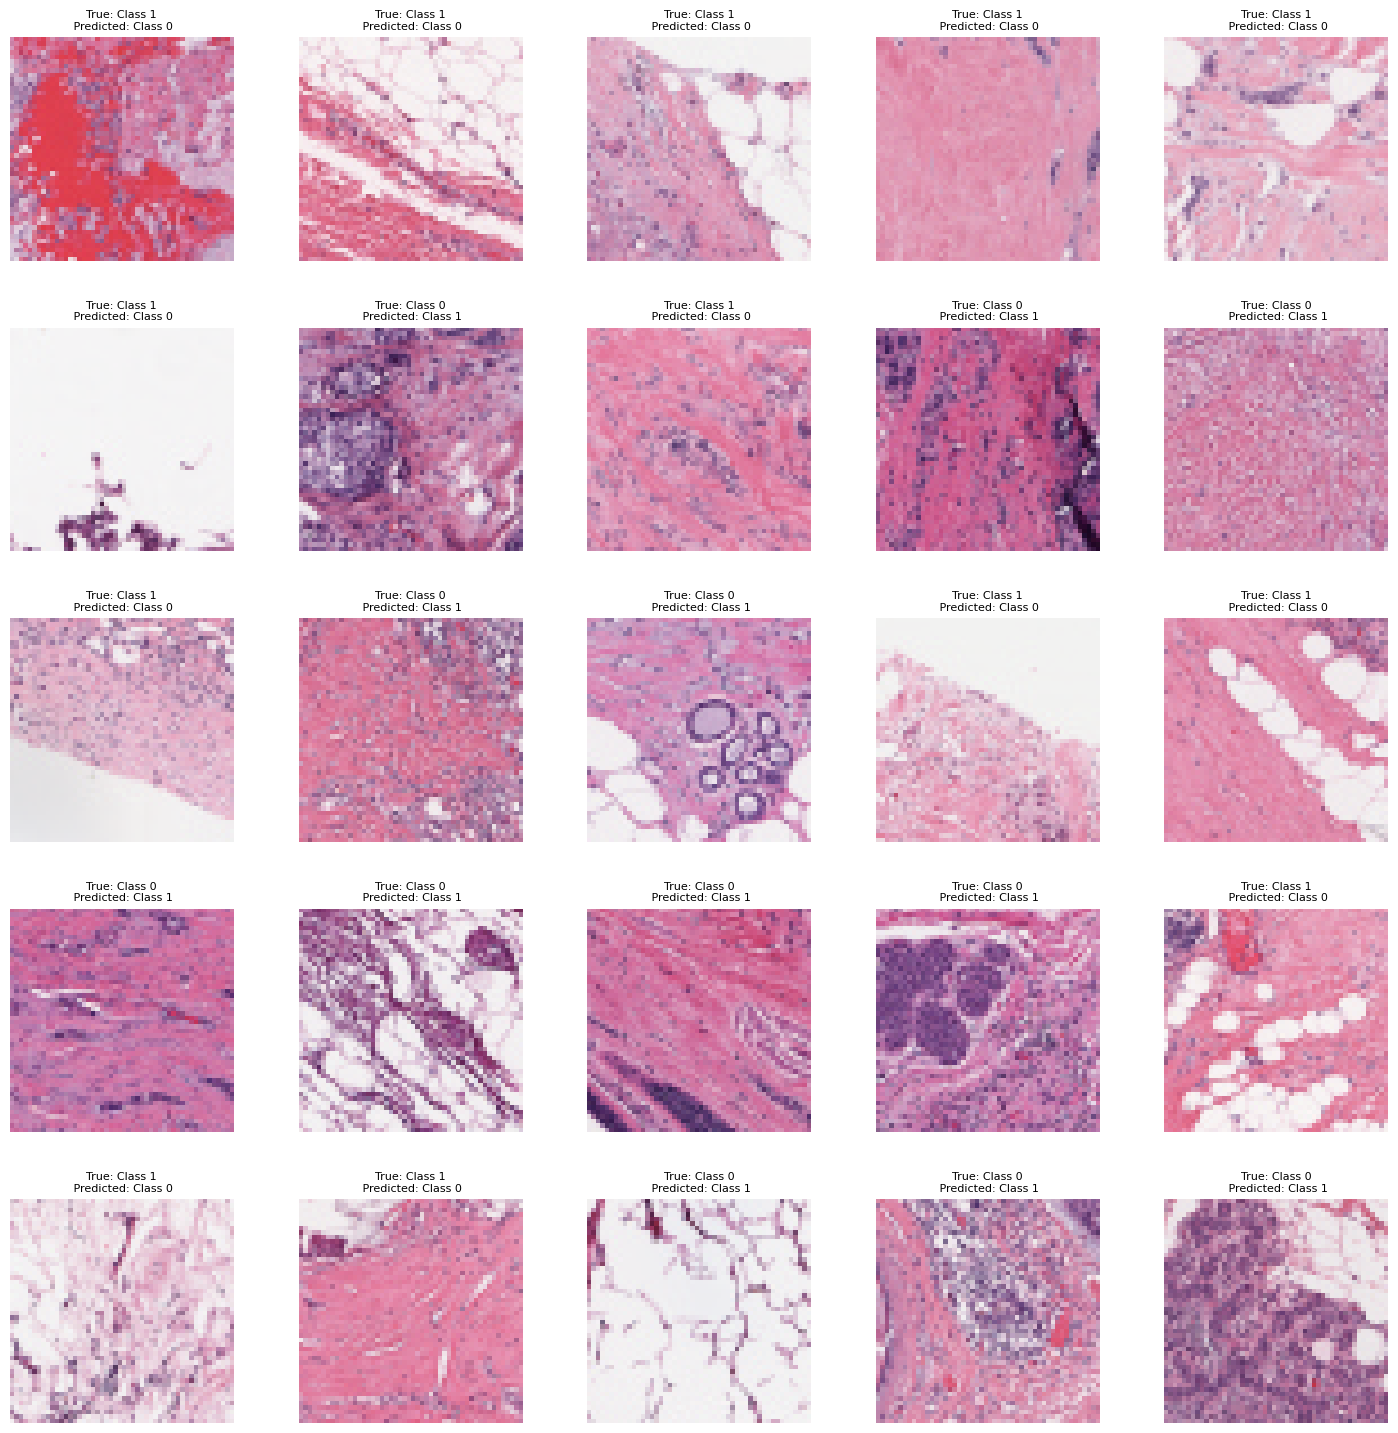

In [ ]:
# Get indices of misclassified images
misclassified_indices = np.where(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))

# Initialize counter
counter = 0

# No of images
num_images = 25

class_labels = {0: 'Class 0', 1: 'Class 1'}  # Replace class labels with your actual labels

# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

x_test1_numpy = np.asarray(list(x_test1.map(lambda x, y: x).unbatch().as_numpy_iterator()))

fig, axes = plt.subplots(L_grid, W_grid, figsize = (18,18))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Iterate through misclassified samples
for i in np.arange(0, W_grid * L_grid):
    if counter < num_images:
        # Load image

        #img = np.asarray(list(x_test1.map(lambda x, y: x).unbatch().as_numpy_iterator()))[misclassified_indices[0][i]]
        img = x_test1_numpy[misclassified_indices[0][i]]
        #img_path = valid_gen.filepaths[misclassified_indices[i]]
        #img = plt.imshow(img)

        # Display image
        axes[i].imshow(img*255)
        axes[i].set_title('True: %s\n Predicted: %s' % (class_labels[np.argmax(y_test[misclassified_indices[0][i]])], class_labels[int(np.argmax(y_pred[misclassified_indices[0][i]]))]), fontsize = 8)
        axes[i].axis('off')
        # Increment counter
        counter += 1

plt.subplots_adjust(hspace=0.3) # for better visualization

#### The correct classifications

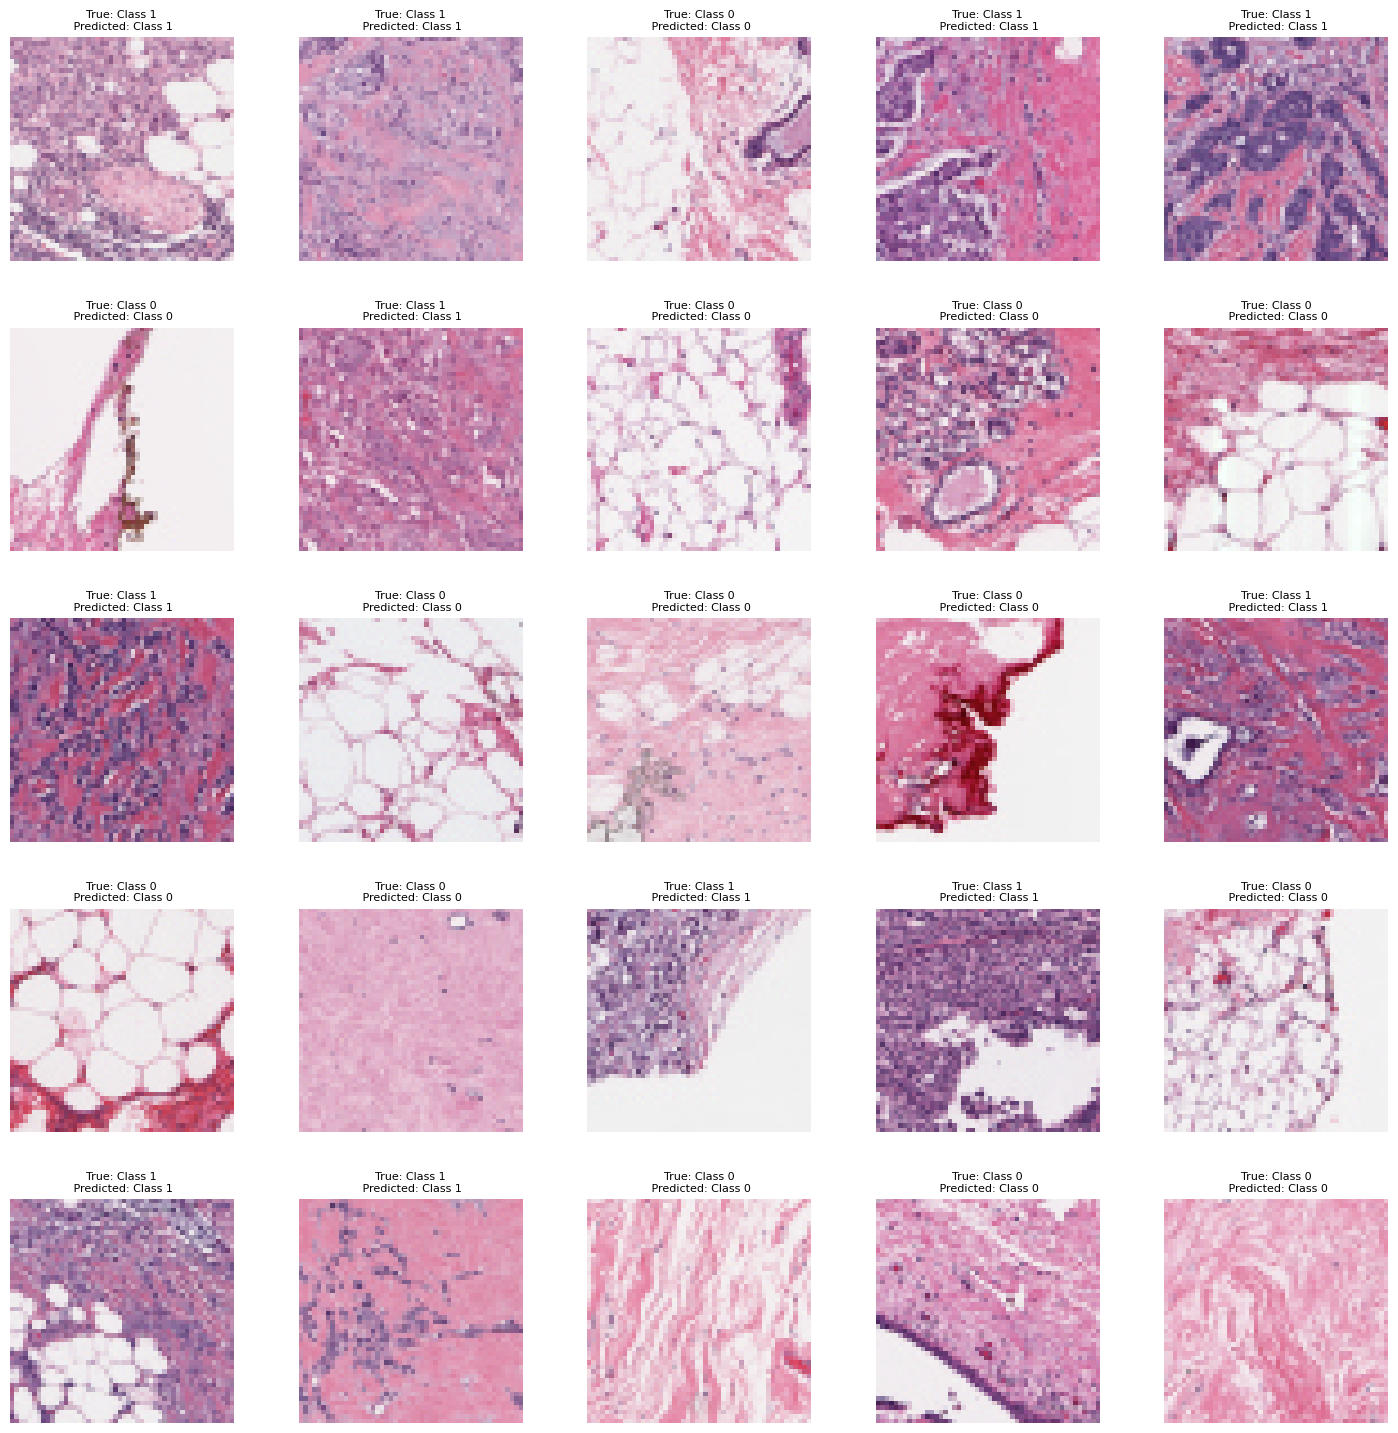

In [ ]:
# Get indices of misclassified images
misclassified_indices = np.where(np.argmax(y_test, axis=1) == np.argmax(y_pred, axis=1))

# Initialize counter
counter = 0

# No of images
num_images = 25

class_labels = {0: 'Class 0', 1: 'Class 1'}  # Replace class labels with your actual labels

# Define the dimensions of the plot grid
W_grid = 5
L_grid = 5

x_test1_numpy = np.asarray(list(x_test1.map(lambda x, y: x).unbatch().as_numpy_iterator()))

fig, axes = plt.subplots(L_grid, W_grid, figsize = (18,18))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Iterate through misclassified samples
for i in np.arange(0, W_grid * L_grid):
    if counter < num_images:
        # Load image

        #img = np.asarray(list(x_test1.map(lambda x, y: x).unbatch().as_numpy_iterator()))[misclassified_indices[0][i]]
        img = x_test1_numpy[misclassified_indices[0][i]]
        #img_path = valid_gen.filepaths[misclassified_indices[i]]
        #img = plt.imshow(img)

        # Display image
        axes[i].imshow(img*255)
        axes[i].set_title('True: %s\n Predicted: %s' % (class_labels[np.argmax(y_test[misclassified_indices[0][i]])], class_labels[int(np.argmax(y_pred[misclassified_indices[0][i]]))]), fontsize = 8)
        axes[i].axis('off')
        # Increment counter
        counter += 1

plt.subplots_adjust(hspace=0.3) # for better visualization